# BLE Proximity Experiment - KNN Classifier
## Experiment based on the measurements of the BLE RSSI values according to the distance to the BLE Estimote beacon

### Imports
Imports of required libraries

In [67]:
#CSV Related
import pandas as pd
import csv

# Machine Learning
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
import sklearn
import scipy

#Graphical Display
%matplotlib inline
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()

# Create color maps
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

plt.style.use('seaborn-whitegrid')

#Additional Helper Libraries
from operator import itemgetter
import re

<Figure size 432x288 with 0 Axes>

### Load File
Function that allows to load a file from disk

In [2]:
#Function that reads a csv file and structures the data accordingly
def load_file(filename):
    dataset = pd.read_csv(filename)
    return dataset

### Initialize Dataset
Initialization of the data from the file

In [3]:
dataset = load_file('../../distance_proximity_experiments.csv')
positions = dataset['coordinate_Y']
dataset['distance'] = positions
#distance_proximity_experiments were made with purple beacon
display(dataset)
display(dataset.shape)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-50,-50.000000,0-1 meters,0.0
1,0.0,0.0,-50,-50.000000,0-1 meters,0.0
2,0.0,0.0,-53,-51.000000,0-1 meters,0.0
3,0.0,0.0,-51,-51.000000,0-1 meters,0.0
4,0.0,0.0,-53,-53.000000,0-1 meters,0.0
...,...,...,...,...,...,...
456,0.0,4.0,-83,-84.250000,3-4 meters,4.0
457,0.0,4.0,-86,-84.600000,3-4 meters,4.0
458,0.0,4.0,-87,-85.000000,3-4 meters,4.0
459,0.0,4.0,-86,-85.142857,3-4 meters,4.0


(461, 6)

### File Overall Description
Usage of describe pandas function on the dataset

In [4]:
display(dataset.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
coordinate_X,461.0,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0
coordinate_Y,461.0,1.973970,1.274489,0.0,1.0,2.00,3.0,4.0
rssi_Value,461.0,-78.206074,9.461756,-94.0,-85.0,-81.00,-75.0,-50.0
rolling_mean_rssi,461.0,-78.065939,9.240107,-91.0,-84.0,-81.25,-76.0,-50.0
distance,461.0,1.973970,1.274489,0.0,1.0,2.00,3.0,4.0


### Scanned Zones
Graphical display of the zones scanned in the experiment

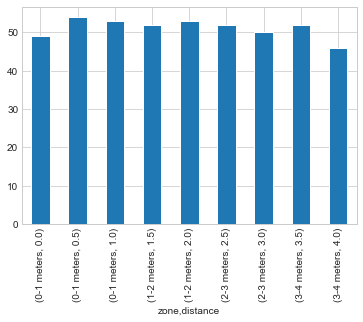

In [6]:
reference_points = dataset.groupby(['zone','distance'])
reference_points.size().plot(kind="bar")

### Beacon RSSI Display
Graphical display of the rssi values recorded at each position

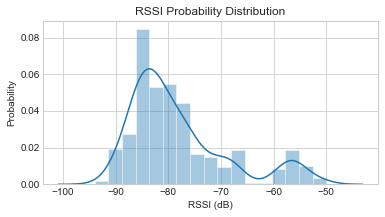

In [7]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')

sns.distplot(dataset['rssi_Value'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Beacon Rolling Mean RSSI Display
Graphical adisplay of the rolling mean value recorded at each position

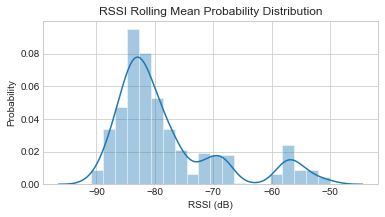

In [8]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Rolling Mean Probability Distribution')
# The KDE plot for the Rolling Mean column
sns.distplot(dataset['rolling_mean_rssi'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Graphical Display of RSSI/Rolling Mean Distribution
Graphical display of the previous measures - rssi and rolling mean

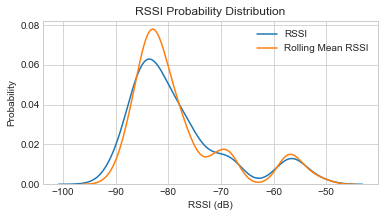

In [9]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')
# The KDE plot for the RSSI column
sns.kdeplot(dataset['rssi_Value'], label='RSSI')
# The KDE plot for the Rolling Mean column
sns.kdeplot(dataset['rolling_mean_rssi'], label='Rolling Mean RSSI')
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Initialize Training Data
Training Data intialization for predictions purposes

In [14]:
train_X_rssi = pd.DataFrame(dataset['rssi_Value']).values.reshape(-1,1)
train_X_rolling_mean = pd.DataFrame(dataset['rolling_mean_rssi']).values.reshape(-1,1)
train_Y = pd.DataFrame(dataset['zone']).values.reshape(-1,1)
default_groups = dataset['zone'].map(str)
data_plot_means = dataset.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

# FREE PARAMETERS
scaler = [StandardScaler(),MinMaxScaler(),MaxAbsScaler(),None]
distance_metris = ["euclidean", "manhattan", "canberra", "braycurtis"]
algorithms = ["brute","kd_tree","ball_tree","auto"]
weights = ["uniform","distance"]

,rssi_Value,rolling_mean_rssi
zone,,
0-1 meters,-69.205128,-69.220368
1-2 meters,-79.952381,-79.981444
2-3 meters,-84.107843,-84.048751
3-4 meters,-84.520408,-83.867310


### Plot Training Data
Graphical Display of the observations in the dataset

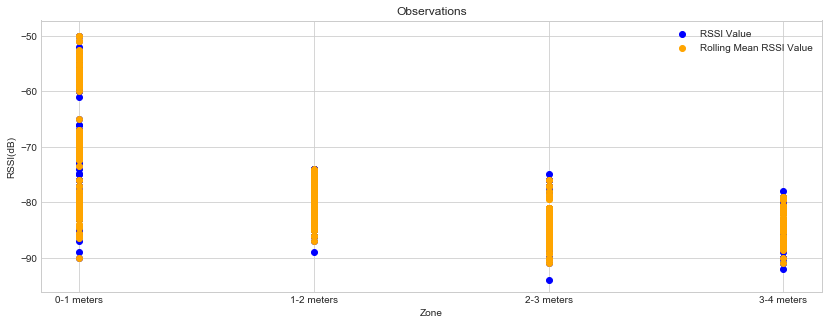

In [17]:
plt.figure(figsize=(14,5))
plt.scatter(dataset['zone'],dataset['rssi_Value'],label='RSSI Value',color='blue')
plt.scatter(dataset['zone'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Statistics Output Format
Structure of the statistical output of each call to the machine learning algorithm

In [18]:
def structure_data(data,precision,accuracy,f1score):
    mae = data['error'].abs().mean()
    mse = np.power(data['error'],2).mean()
    rsme = np.sqrt(mse)
    precision = precision
    accuracy = accuracy
    f1score = f1score
    statistical_results = [mae,mse,rsme,precision,accuracy,f1score]
    return statistical_results

### KNN Classifier Experiments
Experiments with KNN algorithm

In [88]:
def compute_KNN_with_Classifier(flag=0,colors=None,fold=None,trainX_data = None, trainY_data = None,testX_data = None,testY_data = None, scaler = None,
                cross_validation = None,n_neighbors=5,weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski',
                metric_params=None, n_jobs=-1):
    h = .02  # step size in the mesh
    knn_classifier_estimator = KNeighborsClassifier(n_neighbors,weights,algorithm,leaf_size,p,metric,metric_params,n_jobs)
    if scaler is not None:
        # Make pipeline using scaler transformation
        main_estimator = make_pipeline(scaler,knn_classifier_estimator)
    else:
        main_estimator = knn_classifier_estimator
    if cross_validation is None:
        # Fit the training data
        main_estimator.fit(trainX_data,trainY_data)
        # Predict the results of the testing data features
        predict_test = main_estimator.predict(testX_data) 
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    else:
        main_estimator.fit(testX_data,testY_data)
        predict_test = cross_val_predict(main_estimator,testX_data,testY_data,cv = cross_validation,groups=default_groups)
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    statistical_array = list()
    statistics = pd.DataFrame(report).transpose()
    error_dataframe = pd.DataFrame({'Actual': testY_data.flatten(), 'Predicted':predict_test.flatten()})
    if flag == 1:
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
        plt.figure(figsize=(18,10))
        plt.scatter(dataset['zone'],dataset['rssi_Value'],label='RSSI Value',color='blue')
        plt.scatter(dataset['zone'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
        if colors is not None:
            plt.plot(predict_test, testX_data,'s',color=colors,label='KNN Classification' + ' CV : ' +str(fold))
        else:
            plt.plot(predict_test, testX_data,'s',color='red',label='KNN Classification')
        # Show and place the legent
        plt.legend(loc='upper right')
        plt.show()
    error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
    result = pd.DataFrame(train_Y,columns=["zone"]).join(error)
    return structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean())


#### 1st Experiment - Check Overfitting scenario (Without Testing Data) Using RSSI
Use KNN Classifier to check the results on the training data alone

Confusion Matrix:
[[105  48   2   1]
 [  4  92   8   1]
 [ 14  42  36  10]
 [ 14  49  23  12]]


,precision,recall,f1-score,support
0-1 meters,0.766423,0.673077,0.716724,156.000000
1-2 meters,0.398268,0.876190,0.547619,105.000000
2-3 meters,0.521739,0.352941,0.421053,102.000000
3-4 meters,0.500000,0.122449,0.196721,98.000000
accuracy,0.531453,0.531453,0.531453,0.531453
macro avg,0.546608,0.506164,0.470529,461.000000
weighted avg,0.571795,0.531453,0.502245,461.000000


,Actual,Predicted
0,0-1 meters,0-1 meters
1,0-1 meters,0-1 meters
2,0-1 meters,0-1 meters
3,0-1 meters,0-1 meters
4,0-1 meters,0-1 meters
...,...,...
456,3-4 meters,1-2 meters
457,3-4 meters,0-1 meters
458,3-4 meters,3-4 meters
459,3-4 meters,0-1 meters


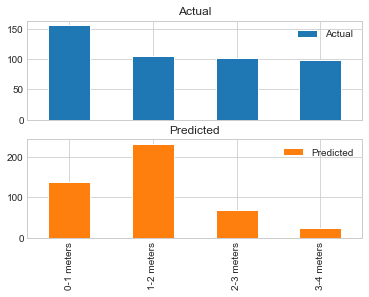

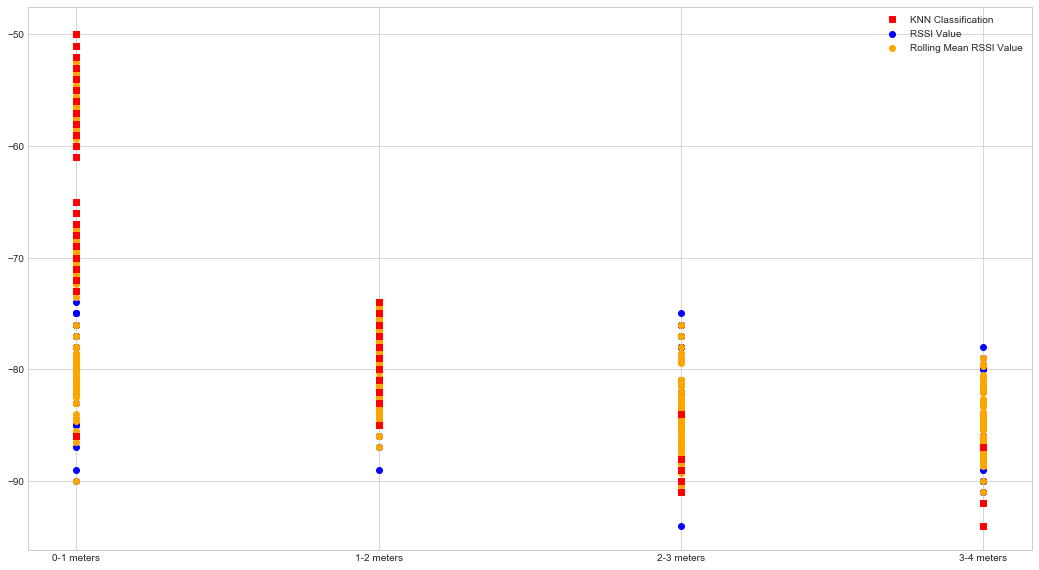

,mae,mse,rmse,precision,accuracy,f1-score
0,0.468547,0.468547,0.684505,0.548041,0.531453,0.483763


In [89]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
result = compute_KNN_with_Classifier(flag=1,trainX_data=train_X_rssi,trainY_data=train_Y.ravel(),
                                   testX_data=train_X_rssi,testY_data=train_Y.ravel(),
                                   scaler=StandardScaler())
statistical_results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=statistical_results)
display(statistics)

#### 2nd Experiment - Check Overfitting scenario (Without Testing Data) Using Rolling Mean
Use KNN to check the results on the training data alone

Confusion Matrix:
[[119  19  11   7]
 [  8  70  19   8]
 [  8  15  61  18]
 [ 17  24  23  34]]


,precision,recall,f1-score,support
0-1 meters,0.782895,0.762821,0.772727,156.000000
1-2 meters,0.546875,0.666667,0.600858,105.000000
2-3 meters,0.535088,0.598039,0.564815,102.000000
3-4 meters,0.507463,0.346939,0.412121,98.000000
accuracy,0.616052,0.616052,0.616052,0.616052
macro avg,0.593080,0.593616,0.587630,461.000000
weighted avg,0.615756,0.616052,0.610921,461.000000


,Actual,Predicted
0,0-1 meters,0-1 meters
1,0-1 meters,0-1 meters
2,0-1 meters,0-1 meters
3,0-1 meters,0-1 meters
4,0-1 meters,0-1 meters
...,...,...
456,3-4 meters,2-3 meters
457,3-4 meters,3-4 meters
458,3-4 meters,1-2 meters
459,3-4 meters,3-4 meters


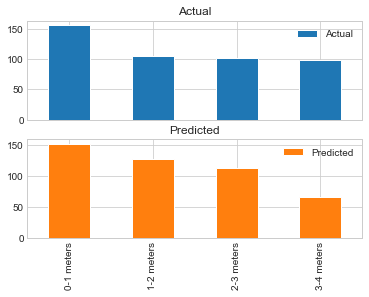

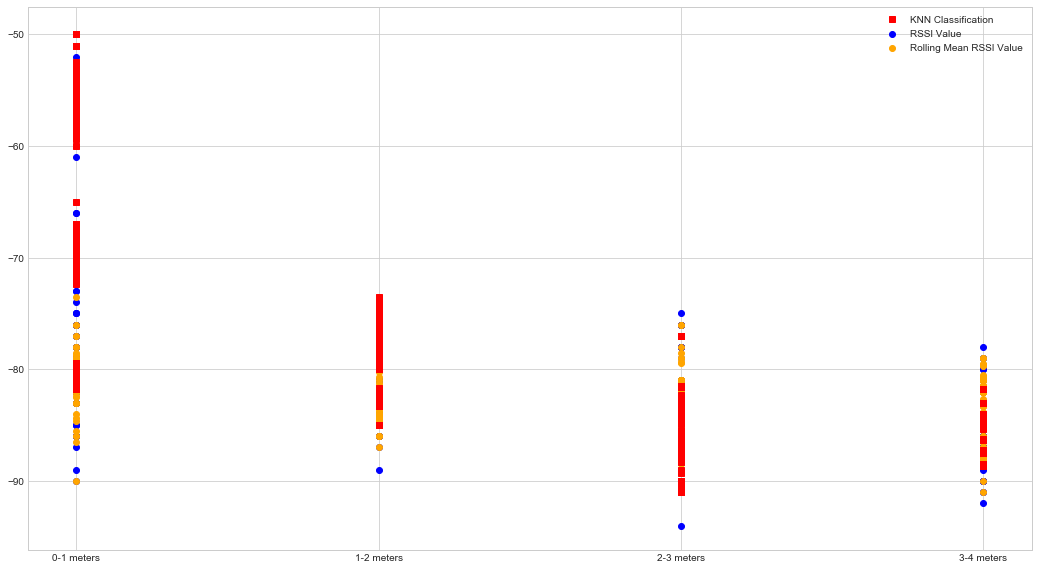

,mae,mse,rmse,precision,accuracy,f1-score
0,0.383948,0.383948,0.619635,0.599601,0.616052,0.595018


In [90]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
result = compute_KNN_with_Classifier(flag=1,trainX_data=train_X_rolling_mean,trainY_data=train_Y.ravel(),
                                   testX_data=train_X_rolling_mean,testY_data=train_Y.ravel(),
                                   scaler=StandardScaler())
statistical_results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=statistical_results)
display(statistics)

#### 3rd Experiment - KNN with StratifiedKFold (RSSI pure)
Experiment using cross validation approach of StratifiedKFold

Confusion Matrix:
[[102  40  14   0]
 [ 36  47  22   0]
 [ 13  36  53   0]
 [ 24  33  41   0]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0-1 meters,0.582857,0.653846,0.616314,156.000000
1-2 meters,0.301282,0.447619,0.360153,105.000000
2-3 meters,0.407692,0.519608,0.456897,102.000000
3-4 meters,0.000000,0.000000,0.000000,98.000000
accuracy,0.438178,0.438178,0.438178,0.438178
macro avg,0.322958,0.405268,0.358341,461.000000
weighted avg,0.356063,0.438178,0.391680,461.000000


,Actual,Predicted
0,0-1 meters,0-1 meters
1,0-1 meters,0-1 meters
2,0-1 meters,0-1 meters
3,0-1 meters,0-1 meters
4,0-1 meters,0-1 meters
...,...,...
456,3-4 meters,2-3 meters
457,3-4 meters,1-2 meters
458,3-4 meters,2-3 meters
459,3-4 meters,1-2 meters


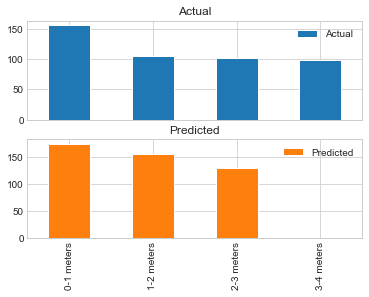

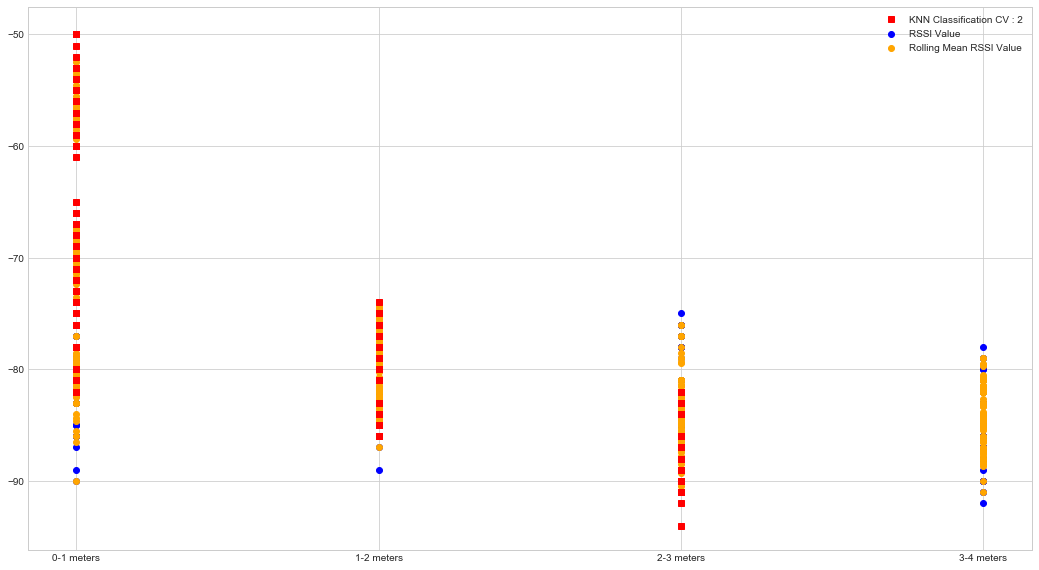

Confusion Matrix:
[[60 83  2 11]
 [40 47  6 12]
 [25 32 23 22]
 [19 23 40 16]]


,precision,recall,f1-score,support
0-1 meters,0.416667,0.384615,0.400000,156.000000
1-2 meters,0.254054,0.447619,0.324138,105.000000
2-3 meters,0.323944,0.225490,0.265896,102.000000
3-4 meters,0.262295,0.163265,0.201258,98.000000
accuracy,0.316703,0.316703,0.316703,0.316703
macro avg,0.314240,0.305247,0.297823,461.000000
weighted avg,0.326297,0.316703,0.310801,461.000000


,Actual,Predicted
0,0-1 meters,0-1 meters
1,0-1 meters,0-1 meters
2,0-1 meters,0-1 meters
3,0-1 meters,0-1 meters
4,0-1 meters,0-1 meters
...,...,...
456,3-4 meters,1-2 meters
457,3-4 meters,3-4 meters
458,3-4 meters,2-3 meters
459,3-4 meters,3-4 meters


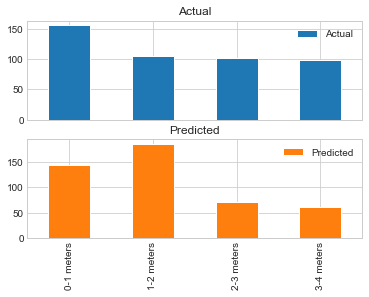

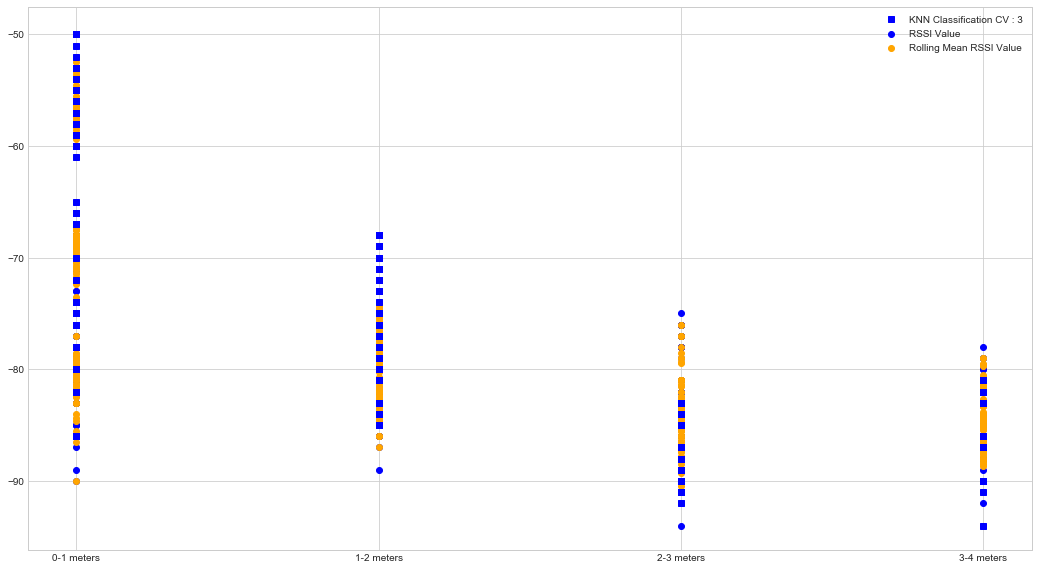

Confusion Matrix:
[[102  30  18   6]
 [ 40  33  31   1]
 [ 20  22  43  17]
 [ 22  30  37   9]]


,precision,recall,f1-score,support
0-1 meters,0.554348,0.653846,0.600000,156.00000
1-2 meters,0.286957,0.314286,0.300000,105.00000
2-3 meters,0.333333,0.421569,0.372294,102.00000
3-4 meters,0.272727,0.091837,0.137405,98.00000
accuracy,0.405640,0.405640,0.405640,0.40564
macro avg,0.361841,0.370384,0.352425,461.00000
weighted avg,0.384677,0.405640,0.382949,461.00000


,Actual,Predicted
0,0-1 meters,0-1 meters
1,0-1 meters,0-1 meters
2,0-1 meters,0-1 meters
3,0-1 meters,0-1 meters
4,0-1 meters,0-1 meters
...,...,...
456,3-4 meters,2-3 meters
457,3-4 meters,1-2 meters
458,3-4 meters,3-4 meters
459,3-4 meters,1-2 meters


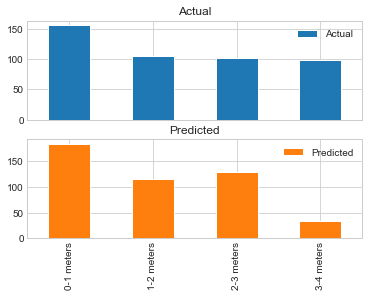

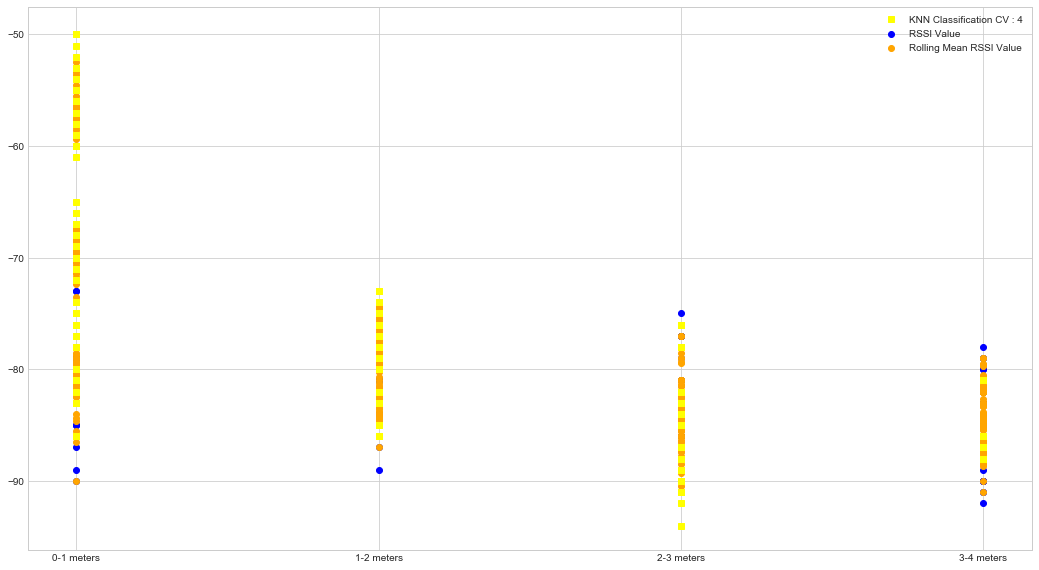

Confusion Matrix:
[[101  29  20   6]
 [ 20  57  23   5]
 [ 17  27  39  19]
 [ 12  31  50   5]]


,precision,recall,f1-score,support
0-1 meters,0.673333,0.647436,0.660131,156.000000
1-2 meters,0.395833,0.542857,0.457831,105.000000
2-3 meters,0.295455,0.382353,0.333333,102.000000
3-4 meters,0.142857,0.051020,0.075188,98.000000
accuracy,0.438178,0.438178,0.438178,0.438178
macro avg,0.376870,0.405917,0.381621,461.000000
weighted avg,0.413750,0.438178,0.417399,461.000000


,Actual,Predicted
0,0-1 meters,0-1 meters
1,0-1 meters,0-1 meters
2,0-1 meters,0-1 meters
3,0-1 meters,0-1 meters
4,0-1 meters,0-1 meters
...,...,...
456,3-4 meters,2-3 meters
457,3-4 meters,2-3 meters
458,3-4 meters,2-3 meters
459,3-4 meters,2-3 meters


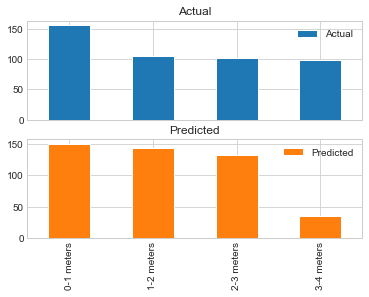

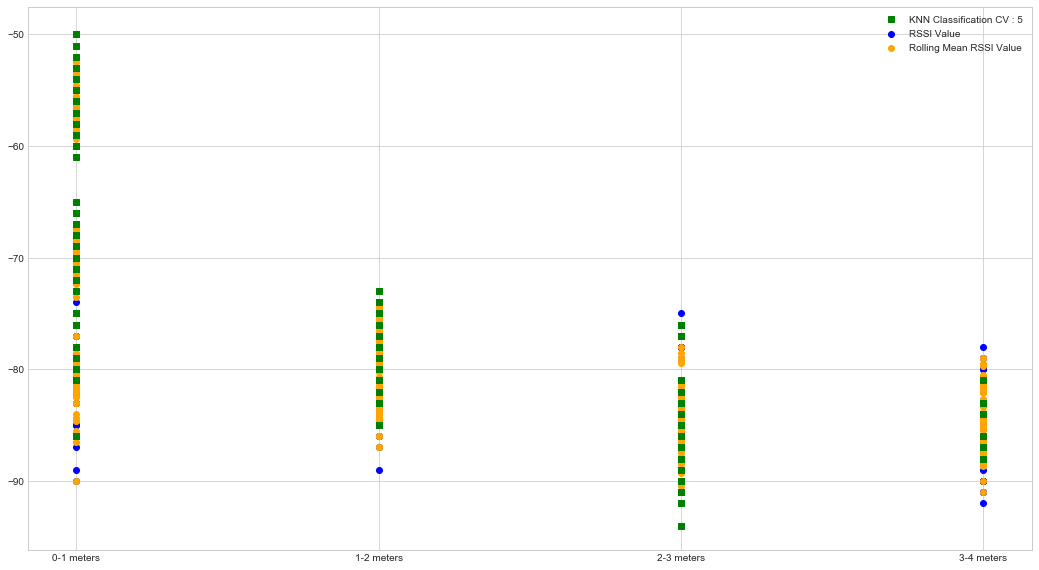

,mae,mse,rmse,precision,accuracy,f1-score,folds
0,0.561822,0.561822,0.749548,0.344147,0.438178,0.374509,2
3,0.561822,0.561822,0.749548,0.390897,0.438178,0.394812,5
2,0.594360,0.594360,0.770948,0.371360,0.405640,0.364388,4
1,0.683297,0.683297,0.826618,0.316314,0.316703,0.302374,3


Number of Folds:  2


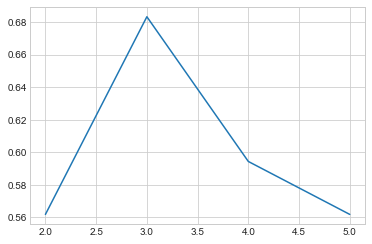

In [95]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
cross_validation_list = np.arange(2,6)
colors = ['red','blue','yellow','green']
counter = 0
results = list()
for cv in cross_validation_list:
    result = compute_KNN_with_Classifier(flag = 1,colors=colors[counter],fold=cv,testX_data=train_X_rssi,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = cv)  
    result.append(cv)
    results.append(result)
    counter = counter + 1
statistical_cols.append('folds')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['folds'],statistics['mae'])
selected_fold = statistics.sort_values(by=['mae'])['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

#### 4th Experiment - KNN with StratifiedKFold (Rolling Mean)
Experiment using cross validation approach of StratifiedKFold

Confusion Matrix:
[[103  17  27   9]
 [ 35  39  22   9]
 [ 21  21  50  10]
 [ 37  18  40   3]]


,precision,recall,f1-score,support
0-1 meters,0.525510,0.660256,0.585227,156.000000
1-2 meters,0.410526,0.371429,0.390000,105.000000
2-3 meters,0.359712,0.490196,0.414938,102.000000
3-4 meters,0.096774,0.030612,0.046512,98.000000
accuracy,0.422993,0.422993,0.422993,0.422993
macro avg,0.348131,0.388123,0.359169,461.000000
weighted avg,0.371495,0.422993,0.388562,461.000000


,Actual,Predicted
0,0-1 meters,0-1 meters
1,0-1 meters,0-1 meters
2,0-1 meters,0-1 meters
3,0-1 meters,0-1 meters
4,0-1 meters,0-1 meters
...,...,...
456,3-4 meters,1-2 meters
457,3-4 meters,2-3 meters
458,3-4 meters,1-2 meters
459,3-4 meters,1-2 meters


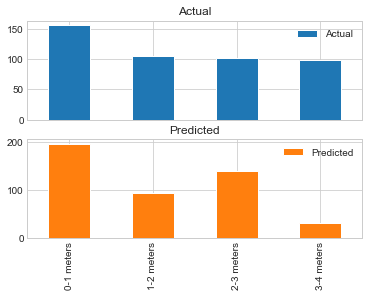

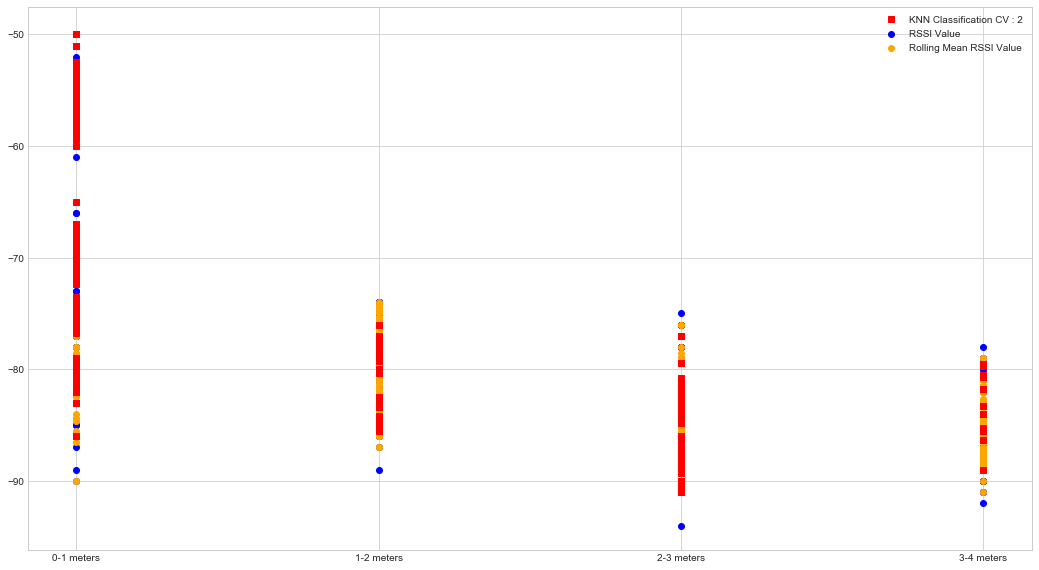

Confusion Matrix:
[[103  26  19   8]
 [ 32  42  23   8]
 [  9  24  46  23]
 [ 27  15  40  16]]


,precision,recall,f1-score,support
0-1 meters,0.602339,0.660256,0.629969,156.000000
1-2 meters,0.392523,0.400000,0.396226,105.000000
2-3 meters,0.359375,0.450980,0.400000,102.000000
3-4 meters,0.290909,0.163265,0.209150,98.000000
accuracy,0.449024,0.449024,0.449024,0.449024
macro avg,0.411287,0.418626,0.408837,461.000000
weighted avg,0.434588,0.449024,0.436390,461.000000


,Actual,Predicted
0,0-1 meters,0-1 meters
1,0-1 meters,0-1 meters
2,0-1 meters,0-1 meters
3,0-1 meters,0-1 meters
4,0-1 meters,0-1 meters
...,...,...
456,3-4 meters,2-3 meters
457,3-4 meters,2-3 meters
458,3-4 meters,1-2 meters
459,3-4 meters,2-3 meters


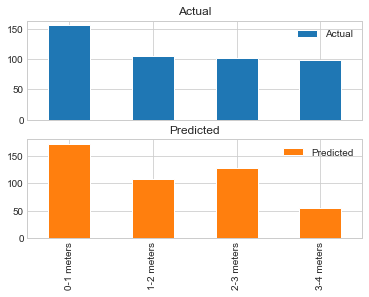

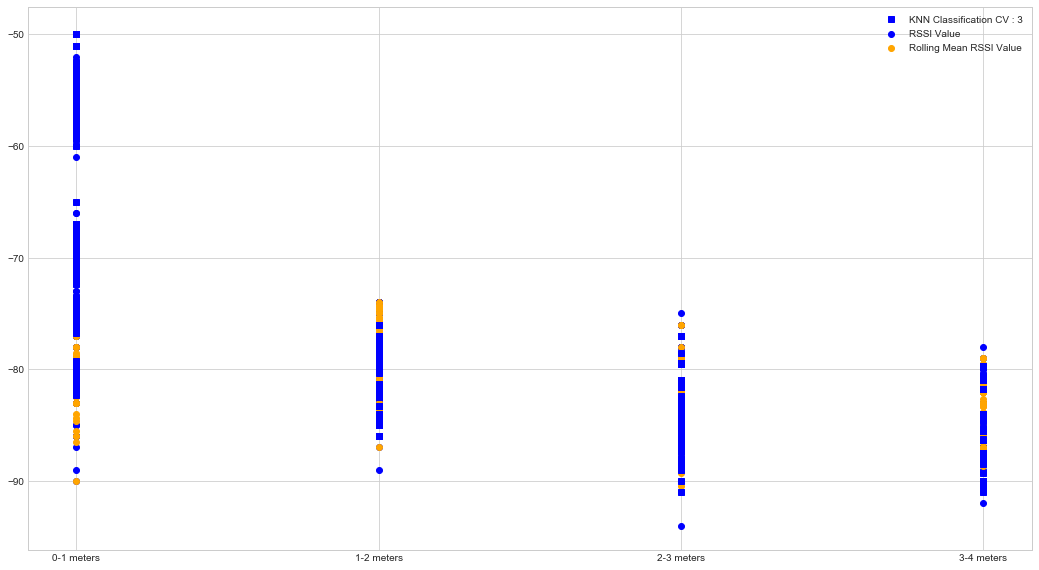

Confusion Matrix:
[[95 27 22 12]
 [28 43 24 10]
 [20 29 30 23]
 [36 14 37 11]]


,precision,recall,f1-score,support
0-1 meters,0.530726,0.608974,0.567164,156.000000
1-2 meters,0.380531,0.409524,0.394495,105.000000
2-3 meters,0.265487,0.294118,0.279070,102.000000
3-4 meters,0.196429,0.112245,0.142857,98.000000
accuracy,0.388286,0.388286,0.388286,0.388286
macro avg,0.343293,0.356215,0.345897,461.000000
weighted avg,0.366765,0.388286,0.373893,461.000000


,Actual,Predicted
0,0-1 meters,0-1 meters
1,0-1 meters,0-1 meters
2,0-1 meters,0-1 meters
3,0-1 meters,0-1 meters
4,0-1 meters,0-1 meters
...,...,...
456,3-4 meters,2-3 meters
457,3-4 meters,2-3 meters
458,3-4 meters,2-3 meters
459,3-4 meters,2-3 meters


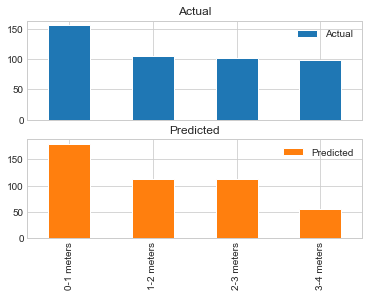

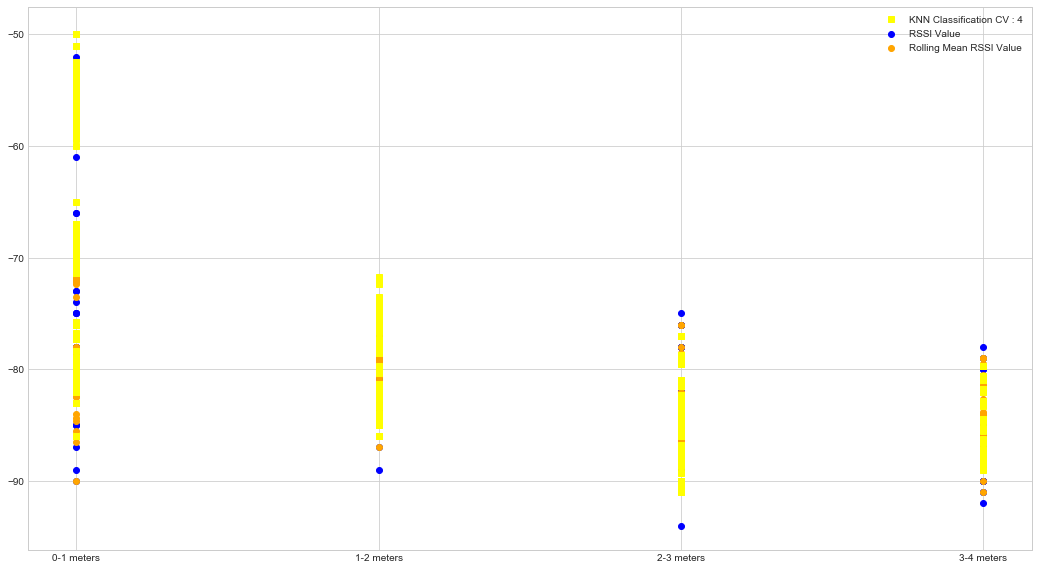

Confusion Matrix:
[[103  23  16  14]
 [ 22  47  28   8]
 [ 15  19  41  27]
 [ 31  10  51   6]]


,precision,recall,f1-score,support
0-1 meters,0.602339,0.660256,0.629969,156.000000
1-2 meters,0.474747,0.447619,0.460784,105.000000
2-3 meters,0.301471,0.401961,0.344538,102.000000
3-4 meters,0.109091,0.061224,0.078431,98.000000
accuracy,0.427332,0.427332,0.427332,0.427332
macro avg,0.371912,0.392765,0.378431,461.000000
weighted avg,0.401853,0.427332,0.411034,461.000000


,Actual,Predicted
0,0-1 meters,0-1 meters
1,0-1 meters,0-1 meters
2,0-1 meters,0-1 meters
3,0-1 meters,0-1 meters
4,0-1 meters,0-1 meters
...,...,...
456,3-4 meters,2-3 meters
457,3-4 meters,2-3 meters
458,3-4 meters,2-3 meters
459,3-4 meters,2-3 meters


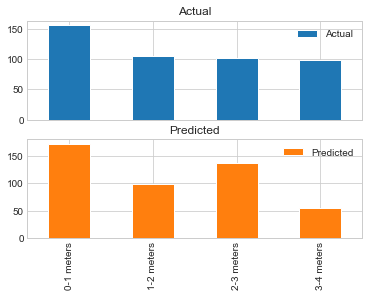

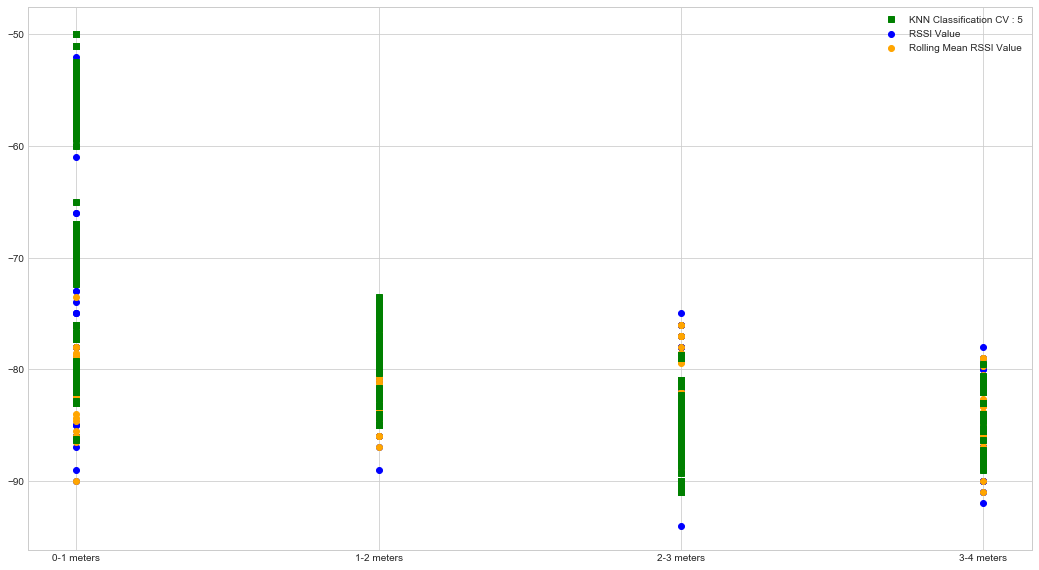

,mae,mse,rmse,precision,accuracy,f1-score,folds
1,0.550976,0.550976,0.742278,0.420006,0.449024,0.418514,3
3,0.572668,0.572668,0.756748,0.384106,0.427332,0.390074,5
0,0.577007,0.577007,0.759609,0.362163,0.422993,0.372486,2
2,0.611714,0.611714,0.782121,0.353074,0.388286,0.355952,4


Number of Folds:  3


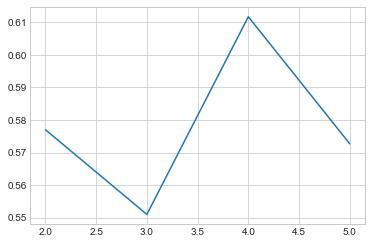

In [96]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
cross_validation_list = np.arange(2,6)
colors = ['red','blue','yellow','green']
counter = 0
results = list()
for cv in cross_validation_list:
    result = compute_KNN_with_Classifier(flag = 1,colors=colors[counter],fold=cv,testX_data=train_X_rolling_mean,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = cv)  
    result.append(cv)
    results.append(result)
    counter = counter + 1
statistical_cols.append('folds')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['folds'],statistics['mae'])
selected_fold = statistics.sort_values(by=['mae'])['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

#### 5th Experiment - KNN with HoldOut (RSSI pure)
Experiment using cross validation approach of HoldOut (Train test split)

,mae,mse,rmse,precision,accuracy,f1-score,test_size
6,0.479876,0.479876,0.692731,0.517206,0.520124,0.508740,0.7
7,0.482385,0.482385,0.694539,0.508980,0.517615,0.495775,0.8
4,0.502165,0.502165,0.708636,0.493533,0.497835,0.484498,0.5
3,0.508108,0.508108,0.712817,0.474003,0.491892,0.471666,0.4
8,0.513253,0.513253,0.716417,0.477915,0.486747,0.471436,0.9
1,0.516129,0.516129,0.718421,0.474403,0.483871,0.465590,0.2
5,0.512635,0.512635,0.715986,0.483921,0.487365,0.464827,0.6
2,0.546763,0.546763,0.739434,0.516818,0.453237,0.426661,0.3
0,0.617021,0.617021,0.785507,0.353291,0.382979,0.355141,0.1


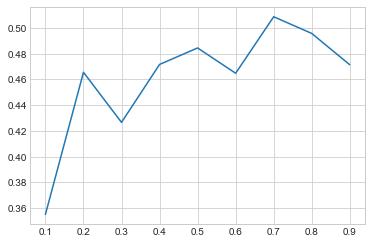

In [94]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = list()
for size in test_sizes:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(train_X_rssi,train_Y.ravel(), test_size = size, random_state = 6,stratify=default_groups)
    result = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    result.append(size)
    results.append(result)
statistical_cols.append('test_size')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.plot(statistics['test_size'],statistics['f1-score'])

#### 6th Experiment - KNN with HoldOut (Rolling Mean)
Experiment using cross validation approach of HoldOut (Train test split)

,mae,mse,rmse,precision,accuracy,f1-score,test_size
0,0.425532,0.425532,0.652328,0.550982,0.574468,0.550754,0.1
7,0.447154,0.447154,0.668696,0.555822,0.552846,0.542095,0.8
1,0.483871,0.483871,0.695608,0.502205,0.516129,0.496255,0.2
4,0.497835,0.497835,0.705575,0.483422,0.502165,0.481310,0.5
5,0.498195,0.498195,0.705829,0.478237,0.501805,0.478903,0.6
6,0.504644,0.504644,0.710383,0.479730,0.495356,0.478285,0.7
3,0.508108,0.508108,0.712817,0.478890,0.491892,0.473860,0.4
8,0.498795,0.498795,0.706254,0.474777,0.501205,0.467200,0.9
2,0.525180,0.525180,0.724693,0.464809,0.474820,0.460795,0.3


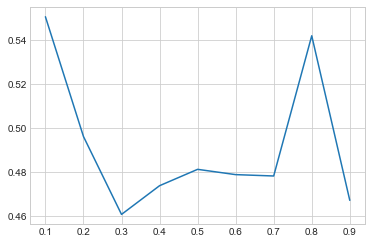

In [97]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = list()
for size in test_sizes:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(train_X_rolling_mean,train_Y.ravel(), test_size = size, random_state = 6,stratify=default_groups)
    result = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    result.append(size)
    results.append(result)
statistical_cols.append('test_size')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.plot(statistics['test_size'],statistics['f1-score'])

#### 7th Experiment - KNN with LOGO (RSSI)
Experiment using cross validation approach of Leave One Group Out

In [99]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
results = list()
cv = LeaveOneGroupOut()
splited = cv.split(train_X_rssi,train_Y.ravel(),groups=default_groups)
loo = compute_KNN_with_Classifier(testX_data=train_X_rssi,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
results.append(loo)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

,mae,mse,rmse,precision,accuracy,f1-score
0,1.0,1.0,1.0,0.0,0.0,0.0


#### 8th Experiment - KNN with LOGO (Rolling Mean)
Experiment using cross validation approach of Leave One Group Out

In [100]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
results = list()
cv = LeaveOneGroupOut()
splited = cv.split(train_X_rolling_mean,train_Y.ravel(),groups=default_groups)
loo = compute_KNN_with_Classifier(testX_data=train_X_rolling_mean,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
results.append(loo)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

,mae,mse,rmse,precision,accuracy,f1-score
0,1.0,1.0,1.0,0.0,0.0,0.0


#### 9th Experiment - Best cross-validation technique
Best parameters found using KNN

,mae,mse,rmse,precision,accuracy,f1-score,method,type
4,0.447154,0.447154,0.668696,0.555822,0.552846,0.542095,HoldOut,Rolling Mean RSSI
1,0.482385,0.482385,0.694539,0.508980,0.517615,0.495775,HoldOut,RSSI Only
5,0.550976,0.550976,0.742278,0.420006,0.449024,0.418514,Stratified K-Fold,Rolling Mean RSSI
2,0.683297,0.683297,0.826618,0.316314,0.316703,0.302374,Stratified K-Fold,RSSI Only
0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,LOO,RSSI Only
3,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,LOO,Rolling Mean RSSI


Selected cross validation method:  HoldOut


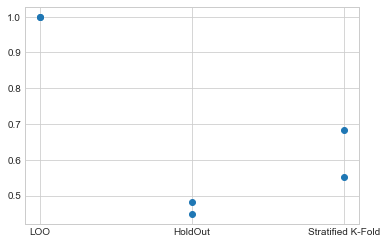

In [102]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','method','type']
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.8, random_state = 6,stratify=default_groups)
    holdout = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    cv = LeaveOneGroupOut()
    splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
    loo = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
    loo.append('LOO')
    loo.append(scannedType)
    results.append(loo)
    holdout.append('HoldOut')
    holdout.append(scannedType)
    results.append(holdout)
    skfold = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = selected_fold)
    skfold.append('Stratified K-Fold')
    skfold.append(scannedType)
    results.append(skfold)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['method'],statistics['mae'],'o')
selected_method = statistics.sort_values(by=['mae'])['method'].head(1).values[0]
print("Selected cross validation method: ",selected_method)

#### 10th Experiment - Best preprocessing technique
Experiment with the different preprocessing techniques

,mae,mse,rmse,precision,accuracy,f1-score,preprocessing,preprocessingFunc,type
6,0.510791,0.510791,0.714697,0.478653,0.489209,0.473975,MaxAbsScaler,MaxAbsScaler(copy=True),Rolling Mean RSSI
7,0.510791,0.510791,0.714697,0.478653,0.489209,0.473975,None,None,Rolling Mean RSSI
5,0.517986,0.517986,0.719712,0.469979,0.482014,0.466505,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",Rolling Mean RSSI
4,0.525180,0.525180,0.724693,0.464809,0.474820,0.460795,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",Rolling Mean RSSI
1,0.539568,0.539568,0.734553,0.520306,0.460432,0.432208,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",RSSI Only
2,0.539568,0.539568,0.734553,0.520306,0.460432,0.432208,MaxAbsScaler,MaxAbsScaler(copy=True),RSSI Only
3,0.539568,0.539568,0.734553,0.520306,0.460432,0.432208,None,None,RSSI Only
0,0.546763,0.546763,0.739434,0.516818,0.453237,0.426661,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",RSSI Only


Selected Preprocessing:  MaxAbsScaler


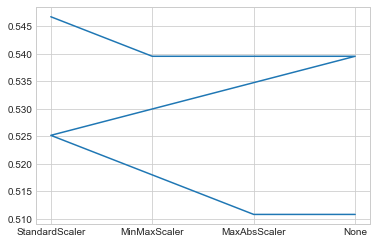

In [103]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','preprocessing','preprocessingFunc','type']
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    for preprocess in scaler:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=preprocess,cross_validation = splited)  
        elif selected_method =='Stratified K-Fold':
            result = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=preprocess,cross_validation = selected_fold)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=preprocess)
        if(preprocess is None):
            regex = 'None'
        else:
            regex = re.search('(\w+)\(',str(preprocess)).group(1)
        result.append(regex)
        result.append(preprocess)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['preprocessing'],statistics['mae'])
selected_preprocessing = statistics.sort_values(by=['mae'])['preprocessing'].head(1).values[0]
selected_preprocesssing_func = statistics.sort_values(by=['mae'])['preprocessingFunc'].head(1).values[0]
print("Selected Preprocessing: ",selected_preprocessing)

#### 11th Experiment -  Running the KNN function with the different weights

,mae,mse,rmse,precision,accuracy,f1-score,weights,type
3,0.517986,0.517986,0.719712,0.479004,0.482014,0.472896,distance,Rolling Mean RSSI
2,0.525180,0.525180,0.724693,0.464809,0.474820,0.460795,uniform,Rolling Mean RSSI
1,0.539568,0.539568,0.734553,0.520306,0.460432,0.432208,distance,RSSI Only
0,0.546763,0.546763,0.739434,0.516818,0.453237,0.426661,uniform,RSSI Only


Selected weight:  distance


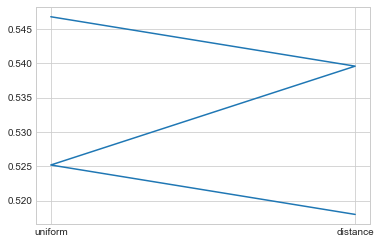

In [104]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','weights','type']
results = list()
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    for weight in weights:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(X_train,Y_train,groups=default_groups)
            result = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                               weights = weight)  
        elif selected_method =='Stratified K-Fold':
            result = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = selected_fold,
                                weights = weight)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                                 scaler=StandardScaler(),
                                               weights = weight)
        result.append(weight)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['weights'],statistics['mae'])
selected_weight = statistics.sort_values(by=['mae'])['weights'].head(1).values[0]
print("Selected weight: ",selected_weight)

#### 12th Experiment - Running the KNN function with the different algorithms

,mae,mse,rmse,precision,accuracy,f1-score,algorithm,type
0,0.496403,0.496403,0.704559,0.487477,0.503597,0.481553,brute,RSSI Only
5,0.525180,0.525180,0.724693,0.464809,0.474820,0.460795,kd_tree,Rolling Mean RSSI
6,0.525180,0.525180,0.724693,0.464809,0.474820,0.460795,ball_tree,Rolling Mean RSSI
7,0.525180,0.525180,0.724693,0.464809,0.474820,0.460795,auto,Rolling Mean RSSI
4,0.532374,0.532374,0.729640,0.456666,0.467626,0.450290,brute,Rolling Mean RSSI
1,0.546763,0.546763,0.739434,0.516818,0.453237,0.426661,kd_tree,RSSI Only
2,0.546763,0.546763,0.739434,0.516818,0.453237,0.426661,ball_tree,RSSI Only
3,0.546763,0.546763,0.739434,0.516818,0.453237,0.426661,auto,RSSI Only


Selected algorithm:  brute


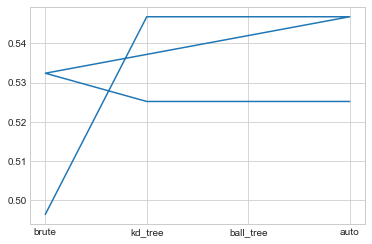

In [105]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','algorithm','type']
results = list()
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    for algorithm in algorithms:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(X_train,Y_train,groups=default_groups)
            result = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                               algorithm= algorithm)  
        elif selected_method =='Stratified K-Fold':
            result = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = selected_fold,
                                algorithm= algorithm)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                                 scaler=StandardScaler(),
                                               algorithm= algorithm)
        result.append(algorithm)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['algorithm'],statistics['mae'])
selected_algorithm = statistics.sort_values(by=['mae'])['algorithm'].head(1).values[0]
print("Selected algorithm: ",selected_algorithm)

#### 13th Experiment - Running the KNN function with the different distance metrics

,mae,mse,rmse,precision,accuracy,f1-score,distance,type
4,0.525180,0.525180,0.724693,0.464809,0.474820,0.460795,euclidean,Rolling Mean RSSI
5,0.525180,0.525180,0.724693,0.464809,0.474820,0.460795,manhattan,Rolling Mean RSSI
6,0.532374,0.532374,0.729640,0.455599,0.467626,0.452587,canberra,Rolling Mean RSSI
7,0.532374,0.532374,0.729640,0.455599,0.467626,0.452587,braycurtis,Rolling Mean RSSI
2,0.539568,0.539568,0.734553,0.520306,0.460432,0.432208,canberra,RSSI Only
3,0.539568,0.539568,0.734553,0.520306,0.460432,0.432208,braycurtis,RSSI Only
0,0.546763,0.546763,0.739434,0.516818,0.453237,0.426661,euclidean,RSSI Only
1,0.546763,0.546763,0.739434,0.516818,0.453237,0.426661,manhattan,RSSI Only


Selected distance:  euclidean


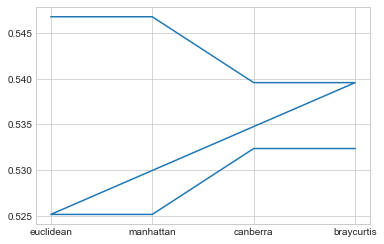

In [106]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','distance','type']
results = list()
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    for distance in distance_metris:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(X_train,Y_train,groups=default_groups)
            result = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                               metric = distance)  
        elif selected_method =='Stratified K-Fold':
            result = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = selected_fold,
                                metric = distance)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                                 scaler=StandardScaler(),
                                               metric = distance)
        result.append(distance)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['distance'],statistics['mae'])
selected_distance = statistics.sort_values(by=['mae'])['distance'].head(1).values[0]
print("Selected distance: ",selected_distance)

#### 14th Experiment - Checking the k parameter

{'knn__n_neighbors': 11}
Max accuracy:  0.5311748381128585


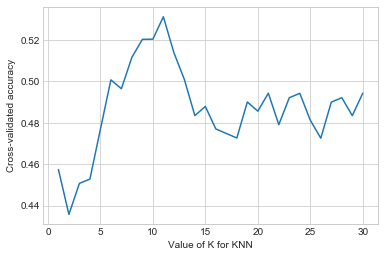

In [111]:
knn_classifier_estimator = KNeighborsClassifier() #init knn regressor estimator
k_range = list(range(1, 31))
param_grid = {'knn__n_neighbors': k_range}
# Create a pipeline
pipe = Pipeline([('standardizer', StandardScaler()), ('knn', knn_classifier_estimator)])
estimator = GridSearchCV(pipe, param_grid,cv=10)
#fit model to data
estimator.fit(train_X_rolling_mean,train_Y.ravel())
print(estimator.best_params_)
grid_mean_scores = estimator.cv_results_['mean_test_score']
print('Max accuracy: ', max(grid_mean_scores))
plt.plot(k_range, grid_mean_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated accuracy')
best_knn = estimator.best_params_['knn__n_neighbors']

### Run GridSearch for parameter tunning

In [116]:
results = []
k_range = list(range(1, 31))
tuned_parameters = {
    'knn__n_neighbors': k_range,
    'knn__metric':distance_metris,
    'knn__weights':weights,
    'knn__algorithm':algorithms
}
scores = ['f1_macro']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    pipe = Pipeline([('standardizer', StandardScaler()), ('knn', KNeighborsClassifier())])
    clf = GridSearchCV(
       pipe, tuned_parameters, cv=selected_fold,scoring=score,n_jobs=-1,verbose=1
    )
    clf.fit(train_X_rolling_mean,train_Y.ravel())
    clf.best_params_['score'] = score
    results.append(clf.best_params_)
gridcv_results = pd.DataFrame(results)
display(gridcv_results)

# Tuning hyper-parameters for f1_macro

Fitting 3 folds for each of 960 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 2646 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:    6.9s finished


,knn__algorithm,knn__metric,knn__n_neighbors,knn__weights,score
0,ball_tree,canberra,19,uniform,f1_macro


### Best Parameters
Display the best parameters tunned throughout the experiments

In [117]:
conclusion_cols=['K Parameter','Cross Validation','Weight','Preprocessing','Algorithm','Distance']
conclusion_list = [best_knn,selected_method,selected_weight,selected_preprocessing,selected_algorithm,selected_distance]
conclusion_pd = pd.DataFrame([conclusion_list],columns= conclusion_cols)
display(conclusion_pd)

,K Parameter,Cross Validation,Weight,Preprocessing,Algorithm,Distance
0,11,HoldOut,distance,MaxAbsScaler,brute,euclidean


### Best Results
Compute KNN with the best parameters in both RSSI and Rolling Mean

In [118]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','type']
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
        result = compute_KNN_with_Classifier(n_neighbors=best_knn,testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                            algorithm=selected_algorithm,metric=selected_distance,
                             weights=selected_weight)  
    elif selected_method =='Stratified K-Fold':
        result = compute_KNN_with_Classifier(n_neighbors=best_knn,testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),
                                             cross_validation = selected_fold,
                            algorithm=selected_algorithm,metric=selected_distance,
                             weights=selected_weight)  
    else:
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
        result = compute_KNN_with_Classifier(n_neighbors=best_knn,trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                             scaler=StandardScaler(),algorithm=selected_algorithm,metric=selected_distance,
                             weights=selected_weight)  
    result.append(scannedType)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
statistical_cols_csv = ['mae','mse','rmse']
statistical_cols_csv.append('Experimentation')
result_csv = result[0:3]
result_csv.append('KNN Classifier')
results_csv = [result_csv]
results_df = pd.DataFrame(columns=statistical_cols_csv,data=results_csv)
results_df.to_csv('../proximity_results.csv',mode='a',index=False)

,mae,mse,rmse,precision,accuracy,f1-score,type
0,0.489209,0.489209,0.699435,0.515579,0.510791,0.502336,RSSI Only
1,0.489209,0.489209,0.699435,0.521085,0.510791,0.505602,Rolling Mean RSSI


### Best Results - Testing data being 1000 plot points
Experiment with testing data of 1000 plot points

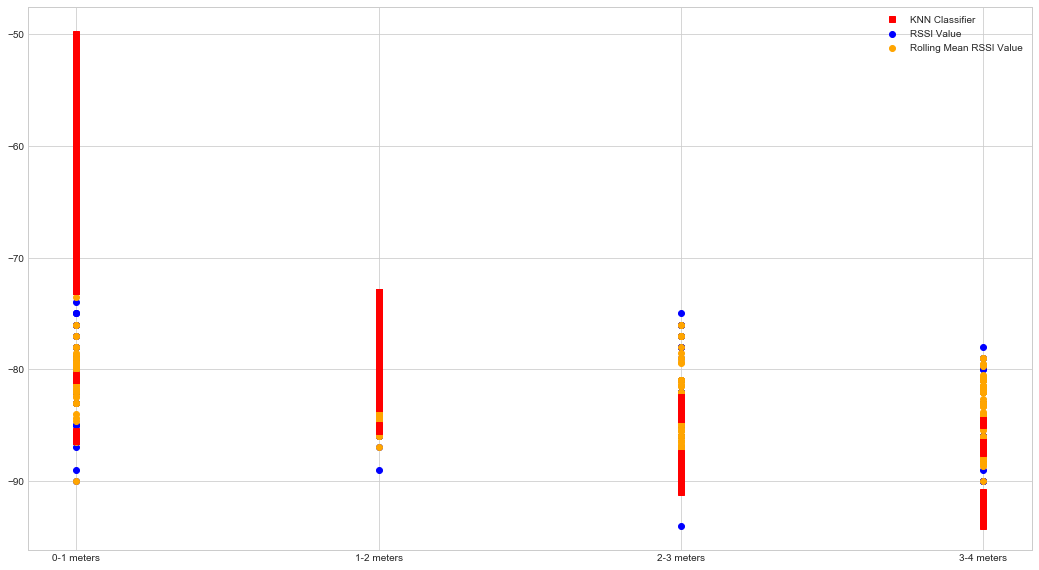

In [122]:
testX_data = np.linspace(dataset['rssi_Value'].min(), dataset['rssi_Value'].max(), 1000).reshape(-1,1)
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
knn_estimator = KNeighborsClassifier()
main_estimator = make_pipeline(StandardScaler(),knn_estimator)
main_estimator.fit(train_X_rssi,train_Y.ravel())
predict_test = main_estimator.predict(testX_data)
plt.show()
plt.figure(figsize=(18,10))
plt.scatter(dataset['zone'],dataset['rssi_Value'],label='RSSI Value',color='blue')
plt.scatter(dataset['zone'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
plt.plot(predict_test, testX_data,'s',color='red', label='KNN Classifier')
# Show and place the legent
plt.legend(loc='upper right')
plt.show()